In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.deterministic import Seasonality, DeterministicProcess, TimeTrend
from statsmodels.tsa.vector_ar import var_model
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


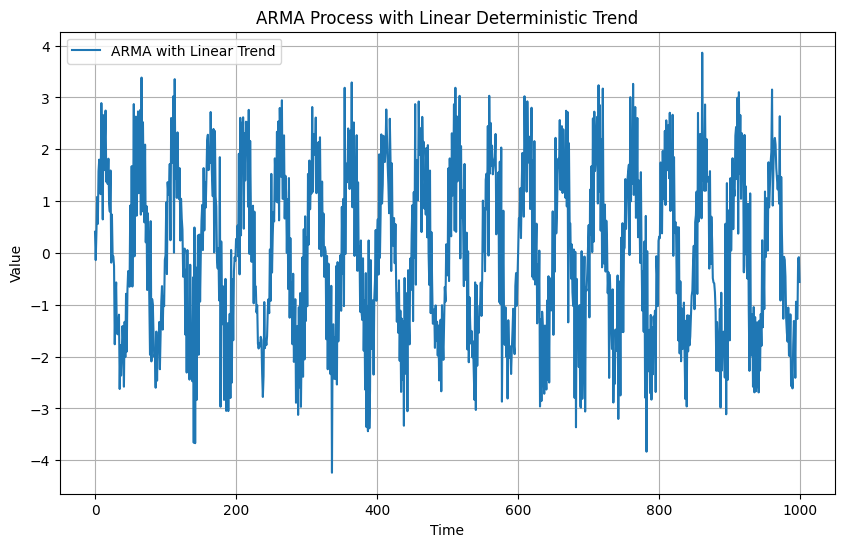

In [2]:
# randomly generate an ARMA(3,4) process
from pandas import date_range


ar = np.array([0.9, 0.5])
ma = np.array([-0.5, 0.2, 0.1])
arma_process = ArmaProcess(ar, ma)

arma_process = arma_process.generate_sample(nsample=1000)

time = np.arange(1000)  # Time index (0 to 999)
b0 = 0  # Intercept
b1 = 0.005  # Slope (rate of change over time)
b2 = 0.001  # Quadratic trend
# linear_trend = b0 + b1 * time + b2 * time**2  # Quadratic trend

noise = np.random.normal(0, 10, 1000)  # White noise

seasonal_period = 50  # Length of the seasonal cycle
seasonal_amplitude = 2  # Amplitude of the seasonal component

seasonality = seasonal_amplitude * np.sin(2 * np.pi * time / seasonal_period)

# Add the linear trend to the ARMA data
sample_data_with_trend = arma_process + seasonality

# Plot the ARMA data with the trend
plt.figure(figsize=(10, 6))
plt.plot(sample_data_with_trend, label="ARMA with Linear Trend")
# plt.plot(linear_trend, label="Linear Trend", linestyle='--', color='red')
plt.title("ARMA Process with Linear Deterministic Trend")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [50]:
time_steps = 10
features_size = 1
batch_size = 64
input_shape = (time_steps, features_size)

units = 128
output_size = 1

In [66]:


# Define a custom RNN cell (e.g., Jordan RNN)
class JordanRNNCell(layers.Layer):
    def __init__(self, units, output_size, activation, **kwargs):
        super(JordanRNNCell, self).__init__(**kwargs)
        self.units = units
        self.output_size = output_size
        self.activation = activation

    @property
    def state_size(self):
        return self.output_size

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Define weights and biases here
        self.W_xh = self.add_weight(shape=(input_dim, self.units), name='W_xh')
        self.W_oh = self.add_weight(shape=(self.output_size, self.units), name='W_oh')
        self.b_h = self.add_weight(shape=(self.units,), name='b_h')
        self.W_hy = self.add_weight(shape=(self.units, self.output_size), name='W_hy')
        self.b_y = self.add_weight(shape=(self.output_size,), name='b_y')

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.matmul(inputs, self.W_xh) + tf.matmul(prev_output, self.W_oh) + self.b_h
        h = tf.nn.tanh(h)
        y = tf.matmul(h, self.W_hy) + self.b_y
        y = self.activation(y)
        return y, [y]

# Wrap the custom cell in an RNN layer
custom_cell = JordanRNNCell(units=units, output_size=output_size, activation=tf.nn.tanh)
rnn_layer = layers.RNN(custom_cell, return_sequences=True, return_state=True)

# Build the model
inputs = layers.Input(input_shape)  # (time_steps, input_dim)
outputs, final_state = rnn_layer(inputs)
predictions = layers.Dense(output_size)(outputs)
jordan_RNN = models.Model(inputs, predictions)
jordan_RNN.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()], run_eagerly=True)
# jordan_RNN.summary()

# # Create a simple RNN that follows the same structure as the custom RNN cell
simple_rnn = models.Sequential([
    layers.InputLayer(input_shape),
    layers.SimpleRNN(units, return_sequences=True, activation='tanh'),
    layers.Dense(output_size)
], name='simple_rnn')
simple_rnn.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()], run_eagerly=True)
# simple_rnn.summary()

multi_layer_rnn = models.Sequential([  
    layers.InputLayer(input_shape),
    layers.SimpleRNN(units, return_sequences=True),
    layers.SimpleRNN(units, return_sequences=True),
    layers.Dense(output_size)
], name='multi_layer_rnn')
multi_layer_rnn.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])
# # multi_layer_rnn.summary()

In [67]:
# jordan_RNN.fit(sample_data_with_trend, sample_data_with_trend, epochs=10, batch_size=32)
# # make sample_data_with trend is set up in 10 time steps
# sample_data_with_trend = sample_data_with_trend.reshape((100, 10))
# jordan_RNN.fit(sample_data_with_trend, sample_data_with_trend, epochs=10)

In [79]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 50  # Number of time steps per sequence
X, y = create_sequences(sample_data_with_trend, 10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch and shuffle
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# check the shape of val_dataset
for x, y in val_dataset:
    print(x.shape, y.shape)


(32, 10) (32,)
(32, 10) (32,)
(32, 10) (32,)
(32, 10) (32,)
(31, 10) (31,)


Epoch 1/50
20/20 [==============================] - 1s 52ms/step - loss: 2.6099 - mean_squared_error: 2.6099
Epoch 2/50
20/20 [==============================] - 1s 50ms/step - loss: 2.6036 - mean_squared_error: 2.6036
Epoch 3/50
20/20 [==============================] - 1s 49ms/step - loss: 2.6026 - mean_squared_error: 2.6026
Epoch 4/50
20/20 [==============================] - 1s 50ms/step - loss: 2.6014 - mean_squared_error: 2.6014
Epoch 5/50
20/20 [==============================] - 1s 49ms/step - loss: 2.6008 - mean_squared_error: 2.6008
Epoch 6/50
20/20 [==============================] - 1s 53ms/step - loss: 2.6001 - mean_squared_error: 2.6001
Epoch 7/50
20/20 [==============================] - 1s 52ms/step - loss: 2.5995 - mean_squared_error: 2.5995
Epoch 8/50
20/20 [==============================] - 1s 51ms/step - loss: 2.5989 - mean_squared_error: 2.5989
Epoch 9/50
20/20 [==============================] - 1s 51ms/step - loss: 2.5984 - mean_squared_error: 2.5984
Epoch 10/50
20/20 [

KeyError: 'val_loss'

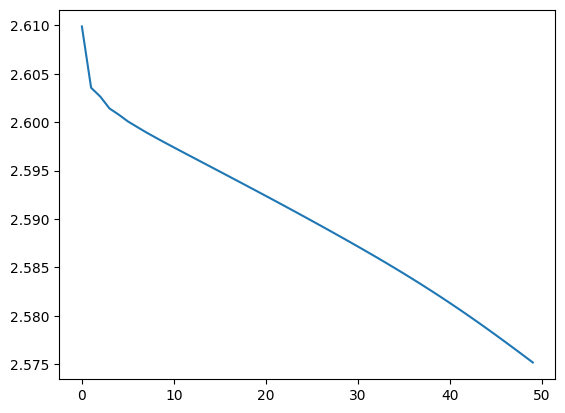

In [81]:
history = simple_rnn.fit(train_dataset, epochs=50)
# calulate f1 score
# simple_rnn.evaluate(test_dataset)
# plot the change in loss
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [62]:
jordan_RNN.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()], run_eagerly=True)
jordan_RNN.fit(train_dataset, epochs=50)
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()



NameError: name 'val_dataset' is not defined

In [63]:
multi_layer_rnn.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()], run_eagerly=True)
multi_layer_rnn.fit(train_dataset, epochs=50)
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

NameError: name 'val_dataset' is not defined